In [1]:
#colab'a veri setimizi yüklüyoruz
import urllib.request
urllib.request.urlretrieve ("https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz","a.tar.gz")
import tarfile
tar = tarfile.open("a.tar.gz")
tar.extractall()
tar.close()

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.8.2'

In [4]:
# Ses sinyallerinin öz niteliklerini çıkartması için kullanılacak
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import os


#VERİ Setinin İncelenmesi
* 10 sınıftan 8732 etiketli kentsel ses alıntısı içerir.
* fold:
Bu dosyanın tahsis edildiği katlama numarası (1-10).Dosyalar önceden on kat halinde sıralanmıştır
(fold1-fold10 adlı klasörler) otomatik sınıflandırma sonuçlarının çoğaltılmasına ve karşılaştırılmasına yardımcı olur
* Sesli alıntılara ek olarak, her bir alıntıyla ilgili meta verileri içeren bir CSV dosyası da sağlanır.
* classID:Ses sınıfının sayısal tanımlayıcısı:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = delme

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music 

In [7]:
data = pd.read_csv('UrbanSound8K.csv')

In [8]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
print(data.shape)
#class sütununu inceleyelim
print(data['class'].unique())

(8732, 8)
['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


In [10]:
#Klasörlerin her birinde veri noktası(datapoints) sayısı
data["fold"].value_counts()


4     990
5     936
3     925
2     888
1     873
7     838
10    837
6     823
9     816
8     806
Name: fold, dtype: int64

#VERİ GÖRSELLEŞTİRME


In [11]:
import librosa ##müzik ve ses analizi için bir python paketidir. Müzik bilgi erişim sistemleri oluşturmak için gerekli yapı taşlarını sağla
import librosa.display

sound_path = "49312-2-0-17.wav"   
signal, sampling_rate = librosa.load(sound_path, sr=None)  # ses dosyasından bir tane seçip dijital hale getirdik

In [12]:
data.slice_file_name

0         100032-3-0-0.wav
1       100263-2-0-117.wav
2       100263-2-0-121.wav
3       100263-2-0-126.wav
4       100263-2-0-137.wav
               ...        
8727       99812-1-2-0.wav
8728       99812-1-3-0.wav
8729       99812-1-4-0.wav
8730       99812-1-5-0.wav
8731       99812-1-6-0.wav
Name: slice_file_name, Length: 8732, dtype: object

In [13]:
print(signal)

[ 0.01905823  0.02488708  0.02877808 ... -0.02586365 -0.03044128
 -0.03533936]


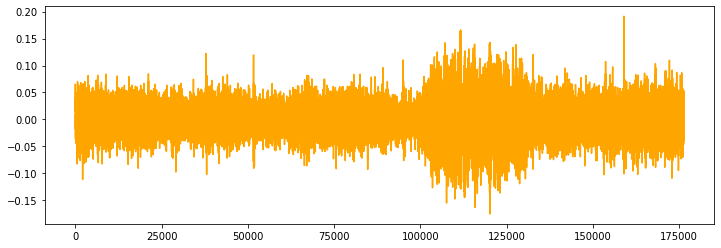

In [14]:
plt.figure(figsize=(12,4))
plt.plot(signal, color='orange')
plt.show()

In [15]:
from IPython import display
display.Audio(signal, rate=sampling_rate)   #seçtiğimiz ses dosyasını çalarek hangi sınıfa ait olduğuna baktık. 
#çocuk sesi

Mel-spectrogram
* İnsan kulakları düşük frekanslı sesleri daha iyi duyar. Bu yüzden spectrogram özniteliğini mel ölçüsüne çekiyoruz.

In [16]:
y,sr=librosa.load("UrbanSound8K/audio/fold5/49312-2-0-17.wav")
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
melspectrogram.shape

(40, 173)

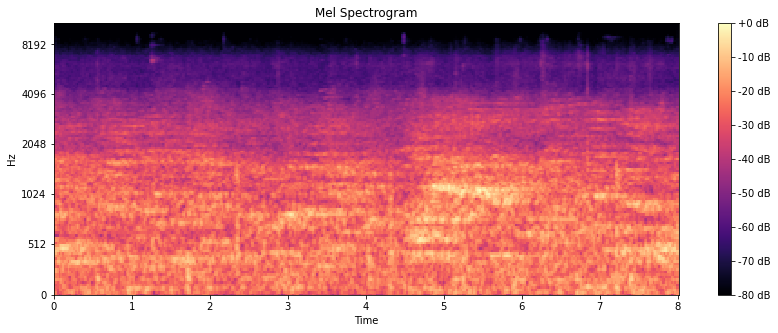

In [17]:
#Bir çocuk sesi havlamasının Melspektrogramı
mel_spect = librosa.feature.melspectrogram(y=signal, sr=sampling_rate)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

VERİ ÖN İŞLEME

In [18]:
y,sr=librosa.load("UrbanSound8K/audio/fold5/49312-2-0-17.wav")
melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=36,fmax=8000).T,axis=0)
melspectrogram.shape

(36,)

In [21]:
features=np.reshape(np.vstack(melspectrogram),(36,1))
features.shape

(36, 1)

In [23]:
x_eğitim=[]
x_test=[]
y_eğitim=[]
y_test=[]

from tqdm import tqdm

path='UrbanSound8K/audio/fold'
for i in tqdm(range(len(data))):
  fold_no=str(data.iloc[i]['fold'])
  file=data.iloc[i]['slice_file_name']
  label=data.iloc[i]['classID']
  filename=path+fold_no+'/'+file
  y,sr=librosa.load(filename)
  melspectrogram = np.mean(librosa.feature.melspectrogram(y=y,sr=sr,n_mels=36,fmax=8000).T,axis=0)
  features=np.reshape(np.vstack((melspectrogram)),(36,1))
  if(fold_no!='10'):
    x_eğitim.append(features)
    y_eğitim.append(label)
  else:
    x_test.append(features)
    y_test.append(label)

 41%|████      | 3555/8732 [12:35<17:35,  4.90it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
 95%|█████████▌| 8325/8732 [28:35<00:55,  7.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
100%|██████████| 8732/8732 [29:51<00:00,  4.87it/s]


In [24]:
len(x_eğitim)

7895

In [25]:
len(x_test)

837

In [26]:
len(data)

8732

In [27]:
#listelerimizi nupy dizisine dönüştürelim
x_eğitim = np.array(x_eğitim)
x_test=np.array(x_test)
y_eğitim=np.array(y_eğitim)
y_test=np.array(y_test)

In [28]:
x_eğitim.shape


(7895, 36, 1)

In [29]:
y_eğitim.shape

(7895,)

In [30]:
x_test.shape


(837, 36, 1)

In [31]:
y_test.shape

(837,)

#VERİ SETLERİMİZİ KAYDEDELİM

In [43]:
#Csv formatında kaydetmek için 2d'ye yeniden şekillendirme.
x_eğitim_2d=np.reshape(x_eğitim,(x_eğitim.shape[0],x_eğitim.shape[1]*x_eğitim.shape[2]))
x_test_2d=np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))

In [44]:
x_eğitim_2d.shape


(7895, 36)

In [45]:
x_test_2d.shape

(837, 36)

In [48]:
#Veri numpy dizilerini kaydetme.
np.savetxt("eğitim_data.csv", x_eğitim_2d, delimiter=",")
np.savetxt("test_data.csv",x_test_2d,delimiter=",")
np.savetxt("eğitim_labels.csv",y_eğitim,delimiter=",")
np.savetxt("test_labels.csv",y_test,delimiter=",")

In [49]:
from google.colab import files

files.download("eğitim_data.csv")
files.download("test_data.csv")
files.download("eğitim_labels.csv")
files.download("test_labels.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>